In [17]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense
import os
import matplotlib.pyplot as plt
from keras.layers import Dropout
tf.device('/gpu:0')
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2041461292839038125
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1838887732
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7141234865891000250
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


Prepare training data
===

In [36]:
# test提高顯存容量
os.environ["TF_CUDA_COMPUTE_PRECOMPILED_KERNELS"] = "0,--maxrregcount=250"

In [3]:
import splitfolders

In [4]:
train_src = "asl_alphabet_train"
splitfolders.ratio(train_src, output="datasets",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False) # 產生trian(訓練集)、val(驗證集)、test(測試集)

In [18]:
train_dir = 'datasets/train'
val_dir = 'datasets/val'
test_dir  = 'datasets/test'

Preprocessing and Get labels
===

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 16
target_size = (224,224)
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
val_datagen   = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
test_datagen  = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
train_generator = train_datagen.flow_from_directory( # 多目錄時，目錄名為標籤
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=True)

val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=False)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=False)

Found 178447 images belonging to 29 classes.
Found 22295 images belonging to 29 classes.
Found 22332 images belonging to 29 classes.


In [20]:
labels = list(train_generator.class_indices.keys())
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [21]:
from PIL import Image
def sample_images(labels): # show image datasets
    num_cols = 8
    num_rows = 4
    fig = plt.figure(figsize=(2*num_cols, 2*num_rows))
    counter = 0  # 用于计数当前子图的索引
    
    for label in labels:
        label_dir = os.path.join(train_dir, label)
        image_files = os.listdir(label_dir)[:num_rows*num_cols]
        
        for image_file in image_files:
            image_path = os.path.join(label_dir, image_file)
            image = Image.open(image_path)
            
            counter += 1  # 更新当前子图的索引
            if counter <= num_rows * num_cols:
                ax = plt.subplot(num_rows, num_cols, counter)
                plt.imshow(image)
                plt.axis("off")
                ax.title.set_text(label)
    
    plt.tight_layout()
    plt.show()

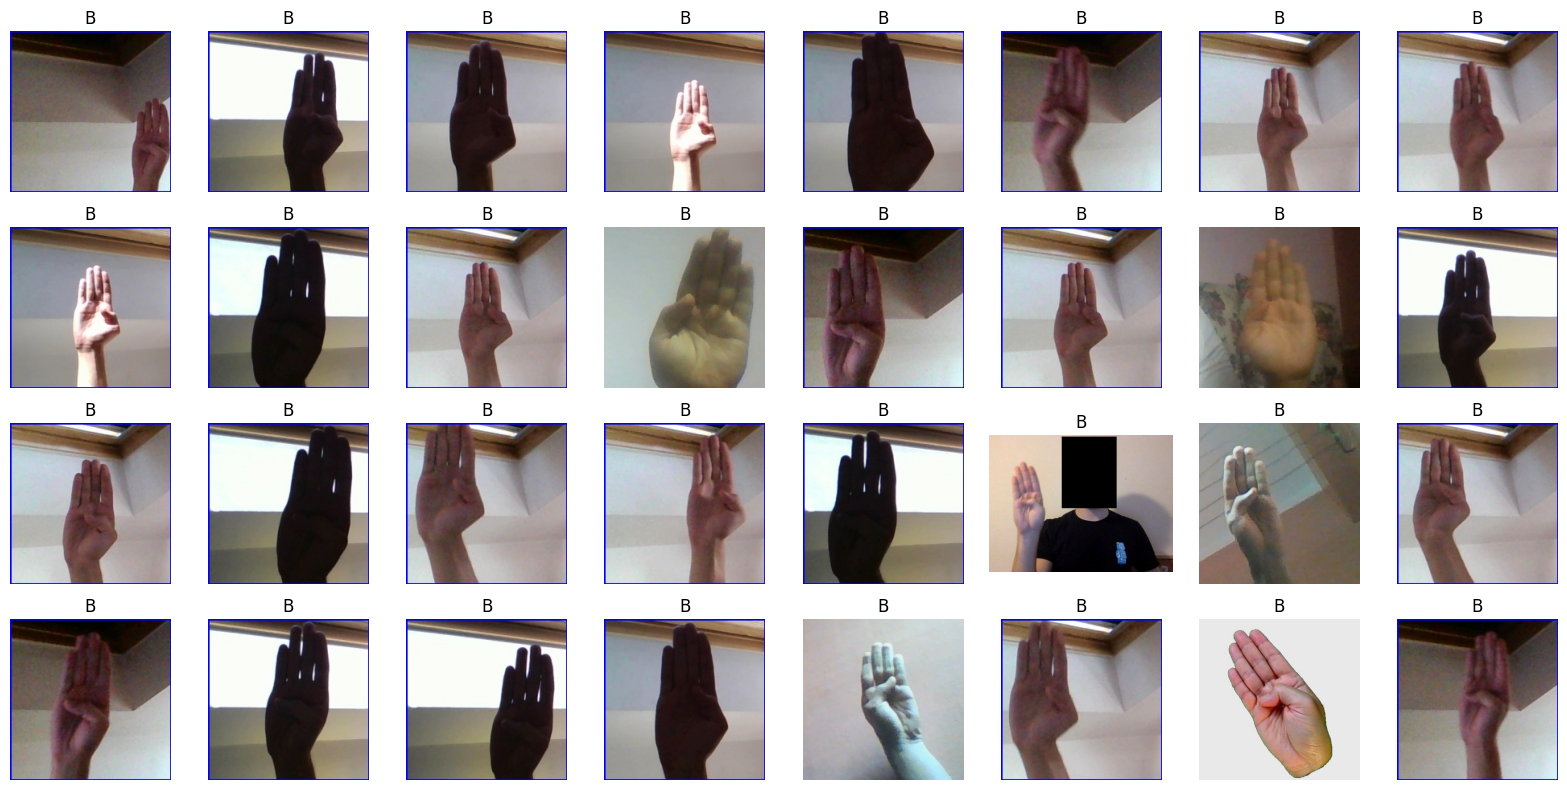

In [22]:
sample_images(labels[1])

Model
===

In [23]:
num_classes = len(labels)
input_shape=(32,32,1)
# cnn body
model = models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

In [47]:
#test 1

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense

num_classes = len(labels)
num_keypoints = 21
embed_dim = 256  
pose_dim = 128

input_shape = (32, 32, 1)

# CNN Backbone
backbone_cnn = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(0.25),
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(0.25),
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(0.25),
    Flatten()
])

# CPNet
keypoint_detector = Dense(num_keypoints*2, activation='linear')
image_embedding = Dense(embed_dim, activation='relu')
pose_encoder = Dense(pose_dim, activation='relu')
gesture_classifier = Dense(num_classes, activation='softmax')

inputs = tf.keras.Input(shape=input_shape)
img_feats = backbone_cnn(inputs)
keypoint_coords = keypoint_detector(img_feats)
pose_embedding = image_embedding(keypoint_coords)
pose_encoding = pose_encoder(pose_embedding)
outputs = gesture_classifier(pose_encoding)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [28]:
# test2 no
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, SeparableConv2D

num_classes = len(labels)
num_keypoints = 21  # 增加关键点数量
embed_dim = 512  # 进一步增加嵌入维度
pose_dim = 256  # 进一步增加姿态编码维度

input_shape = (128, 128, 1)  # 再次增加输入分辨率

# CNN Backbone
backbone_cnn = Sequential([
    Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    SeparableConv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    SeparableConv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    SeparableConv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.25),
    
    SeparableConv2D(512, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Flatten()
])

# CPNet
keypoint_detector = Dense(num_keypoints*2, activation='linear')
image_embedding = Sequential([
    Dense(embed_dim, activation='relu'),
    Dropout(0.5)
])
pose_encoder = Sequential([
    Dense(pose_dim, activation='relu'),
    Dropout(0.5),
    Dense(pose_dim//2, activation='relu'),
    Dropout(0.5)
])
gesture_classifier = Sequential([
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

inputs = tf.keras.Input(shape=input_shape)
img_feats = backbone_cnn(inputs)
keypoint_coords = keypoint_detector(img_feats)
pose_embedding = image_embedding(keypoint_coords)
pose_encoding = pose_encoder(pose_embedding)
outputs = gesture_classifier(pose_encoding)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [38]:
# test3 good 
# epochs=86左右
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop

num_classes = len(labels)
num_keypoints = 21
embed_dim = 256
pose_dim = 128

input_shape = (224, 224, 1)

# CNN Backbone
backbone_cnn = Sequential([
    Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    
    GlobalAveragePooling2D()
])

# CPNet
keypoint_detector = Dense(num_keypoints * 2, activation='linear')
image_embedding = Dense(embed_dim, activation='relu')
pose_encoder = Dense(pose_dim, activation='relu')
gesture_classifier = Dense(num_classes, activation='softmax')

inputs = tf.keras.Input(shape=input_shape)
img_feats = backbone_cnn(inputs)
keypoint_coords = keypoint_detector(img_feats)
pose_embedding = image_embedding(keypoint_coords)
pose_encoding = pose_encoder(pose_embedding)
outputs = gesture_classifier(pose_encoding)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# 使用RMSprop優化器
optimizer = RMSprop(learning_rate=0.001)  # 你可以調整學習率

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
# test4
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Add, Multiply
from tensorflow.keras.optimizers import Adagrad

num_classes = len(labels)
num_keypoints = 21
embed_dim = 512
pose_dim = 256

input_shape = (64, 64, 1)

# CNN Backbone with Attention
backbone_cnn = Sequential([
    Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    
    # Attention Module
    Conv2D(128, kernel_size=(1, 1), activation='relu', padding='same'),
    Conv2D(1, kernel_size=(1, 1), activation='sigmoid', padding='same'),
    
    GlobalAveragePooling2D()
])

# CPNet
keypoint_detector = Dense(num_keypoints * 2, activation='linear')
image_embedding = Dense(embed_dim, activation='relu')
pose_encoder = Dense(pose_dim, activation='relu')
gesture_classifier = Dense(num_classes, activation='softmax')

inputs = tf.keras.Input(shape=input_shape)
img_feats = backbone_cnn(inputs)
attention_map = Multiply()([img_feats, img_feats])  # 元素wise乘法
keypoint_coords = keypoint_detector(attention_map)
pose_embedding = image_embedding(keypoint_coords)
pose_encoding = pose_encoder(pose_embedding)
outputs = gesture_classifier(pose_encoding)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# 使用Adagrad優化器
optimizer = Adagrad(learning_rate=0.0001)  # 你可以調整學習率

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0

def build_model(num_classes):
    # 載入預訓練的 EfficientNet 模型，不包括頂層
    base_model = EfficientNetB0(weights='imagenet', include_top=False)

    # 添加自定義的頂層，用於手勢辨識
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # 組合模型
    model = Model(inputs=base_model.input, outputs=predictions)

    # 凍結預訓練模型的部分層
    for layer in base_model.layers:
        layer.trainable = False

    return model

# 建立手勢辨識模型，假設手勢類別總數為 num_classes
num_classes = 29  # 假設有5個手勢類別
model = build_model(num_classes)

# 編譯模型
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 顯示模型摘要
model.summary()


Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, None,      │          7 │ rescaling[0][0]   │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, None,      │          0 │ normalization[0]… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, None,      │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ stem_conv_pad[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, None,      │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, None,      │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, None,      │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, None,      │          0 │ block1a_activati… │
│ (Multiply)          │ None, 32)         │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │        512 │ block1a_se_excit

 Total params: 5,391,040 (20.57 MB)

 Trainable params: 1,341,469 (5.12 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [39]:
model.summary()

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 128)            │        94,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 42)             │         5,418 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 147,143 (574.78 KB)

 Trainable params: 146,695 (573.03 KB)

 Non-trainable params: 448 (1.75 KB)

Start training
===

In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [41]:
checkpoint_path = "model/B_best_model.keras"
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

In [42]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [43]:
history = model.fit(train_generator, validation_data=val_generator, epochs=15, callbacks=[checkpoint])

Epoch 1/15
10293/11153 ━━━━━━━━━━━━━━━━━━━━ 25s 29ms/step - accuracy: 0.2781 - loss: 2.3557

I0000 00:00:1715597115.163156    1268 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2051', 8 bytes spill stores, 8 bytes spill loads



11152/11153 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2896 - loss: 2.3121
Epoch 1: val_accuracy improved from -inf to 0.20789, saving model to model/B_best_model.keras
11153/11153 ━━━━━━━━━━━━━━━━━━━━ 365s 32ms/step - accuracy: 0.2896 - loss: 2.3120 - val_accuracy: 0.2079 - val_loss: 6.2585
Epoch 2/15
11153/11153 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6335 - loss: 1.1073
Epoch 2: val_accuracy did not improve from 0.20789
11153/11153 ━━━━━━━━━━━━━━━━━━━━ 342s 31ms/step - accuracy: 0.6335 - loss: 1.1073 - val_accuracy: 0.1604 - val_loss: 8.2962
Epoch 3/15
11153/11153 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7203 - loss: 0.8379
Epoch 3: val_accuracy improved from 0.20789 to 0.70455, saving model to model/B_best_model.keras
11153/11153 ━━━━━━━━━━━━━━━━━━━━ 342s 31ms/step - accuracy: 0.7203 - loss: 0.8379 - val_accuracy: 0.7046 - val_loss: 0.9919
Epoch 4/15
11152/11153 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7671 - loss: 0.6936
Epoch 4: val_accuracy did not imp

In [44]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(['Train', 'Validation'], loc='upper right')
# plt.show()

In [45]:
scores = model.evaluate(test_generator) 
print('Test loss: ', scores[0])
print('Test accuracy: ', scores[1])

1391/1396 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7553 - loss: 1.1195

I0000 00:00:1715602044.477514    3764 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_160', 8 bytes spill stores, 8 bytes spill loads



1396/1396 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.7553 - loss: 1.1192
Test loss:  1.0586243867874146
Test accuracy:  0.7577467560768127


In [46]:
model.save("model/B_best_mode3.keras")